# RA-HMC Dual Averaging in high dimensions
### Notebook
---

In [ ]:
using Revise, DrWatson
@quickactivate "ra-hmc"

In [2]:
using main
using Distributions, LinearAlgebra, Plots, Pipe, ProgressMeter
using ForwardDiff, NNlib, Zygote

gr(
    fmt=:png, 
    levels=5, lw=0.1, la=0.1, legend=:topright,
    msa=0.1, msw=0.1, ma=0.25, msc=:firebrick1, 
    xguidefontsize=9, tickfontsize=7
)
ProgressMeter.ijulia_behavior(:clear);

#### Functions for generating plots

In [3]:
cls = palette(:linear_wcmr_100_45_c42_n256, 100, rev=false)

function plt(d=2; lim=(-5, 5), l=200, kwargs...)
    sq = range(lim..., length=l)
    if d == 2
        contourf(
            sq, sq, 
            (x, y) -> model(d).f([x; y; fill(0, model(d).d - 2)]), 
            c=cls, lw=0.1; kwargs...
        )
    elseif d >= 3
        contourf(
            sq, sq, 
            (x, y) -> exp(-model(d).U([x; y; fill(0, model(d).d - 2)])), 
            c=cls, lw=0.1; kwargs...
        )
    end
end

function make_plot(x, d, lim; cb=false, kwargs...)
    k = sample(1:d, 2, replace=false)
    p = plot(plt(d; lim=lim), x -> 0, lim..., ma=0, lw=0, la=0, label="d=$d")
    # p = plot(x -> 0, lim..., ma=0, lw=0, la=0, label="d=$d")
    p = plot(p, x[:, k[1]], x[:, k[2]], c=:black, lw=0.1, la=0.25, ratio=1, label="")
    p = scatter(
        p,
        x[:, k[1]], 
        x[:, k[2]], 
        label="RA-HMC"; c=:darkorange,
        ratio=1, grid=false, legend=:bottomright, ma=0.25, cb=cb, kwargs...
    )
end

function bures(m1, m2, s1, s2)
    a = norm(m1 - m2)^2
    b = tr(sqrt(sqrt(s1) * s2 * sqrt(s1)))
    c = tr(s1) + tr(s2) - 2 * b
    return sqrt(a + c)
end

function w2(X, d; times=10)
    avg_w2 = zeros(times)
    for i in 1:times
        Y = rand(model(d).ξ, size(X, 1))' |> Matrix
        avg_w2[i] = bures(mean(X), mean(Y), cov(X), cov(Y))
    end
    return mean(avg_w2)
end

w2 (generic function with 1 method)

In [4]:
function model(d)
    μ = ([-5, +5] .* fill(ones(d)) ./ √d)
    Σ = fill(2.0 / d, 2)
    S = 1 ./ Σ
    
    ξ = MixtureModel([MvNormal(x, sqrt(y)) for (x, y) in zip(μ, Σ)])
    
    # f(x) = [-sum(abs2, x .- m) * s for (m, s) in zip(μ, S)] .|> exp |> sum
    # U(x) = -logsumexp([-sum(abs2, x .- m) * s for (m, s) in zip(μ, S)])
    # DU(x) = Zygote.gradient(U, x)[1]
    # return Model(ξ=ξ, f=f, U=U, dU=DU)
    
    return Model(ξ=ξ)
end

model (generic function with 1 method)

---
### $\mathbb R^3$

In [5]:
d = 3
@time s, a = mcmc(
    DualAverage(λ=20.0, δ=0.65), RAHMC(),
    model(d); n=5_000, n_burn=1_000
)
x_rahmc_3 = s[a, :];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26
  RAHMC(0.9779073823766989, 20, 0.9789580535650273, Any[]):  0.639872025594881


Acceptance Ratio = 0.6399
 27.902359 seconds (45.11 M allocations: 2.364 GiB, 2.72% gc time, 82.78% compilation time: 0% of which was recompilation)


In [6]:
w2(x_rahmc_3, 3)

0.1829090022938624

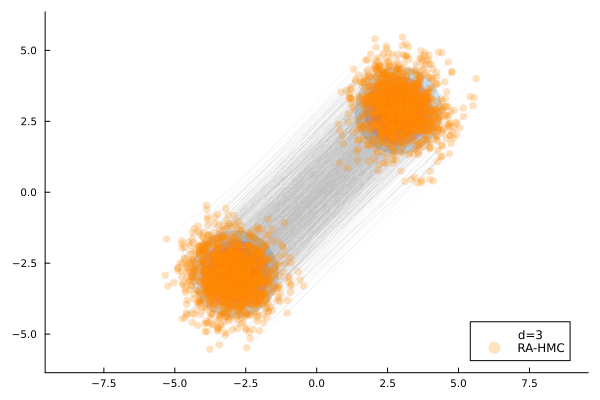

In [7]:
make_plot(x_rahmc_3, 3, (-6, 6))

---
### $\mathbb R^{10}$

In [8]:
d = 10
@time s, a = mcmc(
    DualAverage(λ=25.0, δ=0.65), RAHMC(),
    model(d); n=5_000, n_burn=1_000
)
x_rahmc_10 = s[a, :];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:19
  RAHMC(0.4234763488576569, 59, 1.2729807754717277, Any[]):  0.6510697860427914


Acceptance Ratio = 0.6511
 19.450396 seconds (53.66 M allocations: 5.890 GiB, 8.48% gc time, 4.00% compilation time)


In [9]:
w2(x_rahmc_10, 10)

0.12861959638127038

---
### $\mathbb R^{50}$

In [10]:
d = 50
@time s, a = mcmc(
    DualAverage(λ=40.0, δ=0.65), RAHMC(),
    model(d); n=5_000, n_burn=1_000
)
x_rahmc_50 = s[a, :];

Progress: 100%|█████████████████████████████████████████| Time: 0:31:01
  RAHMC(0.015522086504607215, 2577, 0.46123340644286426, Any[]):  0.3675264947010598


Acceptance Ratio = 0.3675
1861.357970 seconds (2.62 G allocations: 2.974 TiB, 9.60% gc time, 0.04% compilation time)


In [11]:
w2(x_rahmc_50, 50)

0.27791304636481656

---
### $\mathbb R^{100}$

In [13]:
d = 100
@time s, a = mcmc(
    DualAverage(λ=45.0, δ=0.65), RAHMC(),
    model(d); n=5_000, n_burn=1_000
)
x_rahmc_100 = s[a, :];

Progress: 100%|█████████████████████████████████████████| Time: 2:13:16
  RAHMC(0.007254891037789367, 6203, 0.42511301102598287, Any[]):  0.7494501099780044


Acceptance Ratio = 0.7495
7996.643853 seconds (7.79 G allocations: 23.112 TiB, 11.68% gc time, 0.00% compilation time)


In [14]:
w2(x_rahmc_100, 100)

0.17036802344525787

---

## Comparison

In [15]:
d = [3, 10, 50, 100];
xs_d = [x_rahmc_3, x_rahmc_10, x_rahmc_50, x_rahmc_100];

In [16]:
res = map(w2, xs_d, d)
res

4-element Vector{Float64}:
 0.16380121118921503
 0.12388834018329994
 0.2766279940258404
 0.17013070204248681

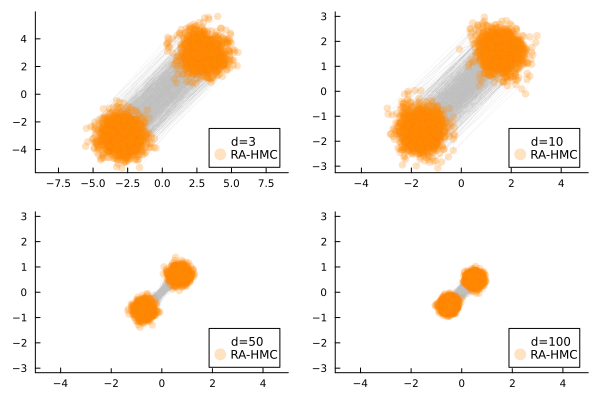

In [17]:
@pipe map((x, d) -> make_plot(x, d, (-3, 3)), xs_d, d) |> 
    plot(_..., layout=(2, 2))

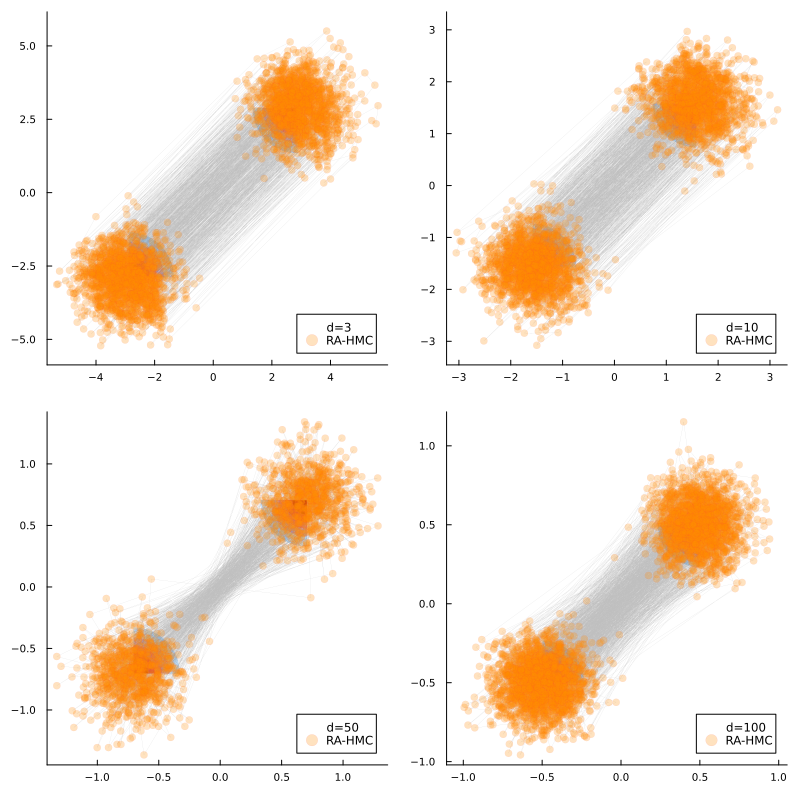

In [18]:
@pipe map((x, d) -> make_plot(x, d, (-5, 5)  ./ sqrt(d)), xs_d, d) |> 
    plot(_..., layout=(2, 2), size=(800, 800))

---